In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.2'
spark_version = 'spark-3.5.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,553 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 http://security.ubuntu.com

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark: SparkSession = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# 1. Read in the csv into a DataFrame.
from pyspark import SparkFiles
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
spark.sparkContext.addFile(url)
energydata_df = spark.read.csv(SparkFiles.get("energydata_complete.csv"), sep=",", header=True)
energydata_df.show()



+-------------------+----------+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|               date|Appliances|lights|                T1|              RH_1|                T2|              RH_2|                T3|              RH_3|                T4|              RH_4|                T5|              RH_5|                  T6|               RH_6|                T7|              RH_7|                T8|              RH_8|                T9|              RH_9|               T_out|       Press_mm_hg|             RH_out|       

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)

# Renaming columns
data = data.rename(columns={
    'Appliances': 'Appliances',
    'lights': 'Lights',
    'T1': 'Kitchen_Temp',
    'RH_1': 'Kitchen_Humidity',
    'T2': 'LivingRoom_Temp',
    'RH_2': 'LivingRoom_Humidity',
    'T3': 'LaundryRoom_Temp',
    'RH_3': 'LaundryRoom_Humidity',
    'T4': 'OfficeRoom_Temp',
    'RH_4': 'OfficeRoom_Humidity',
    'T5': 'Bathroom_Temp',
    'RH_5': 'Bathroom_Humidity',
    'T6': 'OutsideNorth_Temp',
    'RH_6': 'OutsideNorth_Humidity',
    'T7': 'IroningRoom_Temp',
    'RH_7': 'IroningRoom_Humidity',
    'T8': 'TeenagerRoom_Temp',
    'RH_8': 'TeenagerRoom_Humidity',
    'T9': 'ParentRoom_Temp',
    'RH_9': 'ParentRoom_Humidity',
    'T_out': 'Outside_Temp',
    'Press_mm_hg': 'Atmospheric_Pressure',
    'RH_out': 'Outside_Humidity',
    'rv1': 'Random_Var1',
    'rv2': 'Random_Var2'

})

# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'])

# Feature engineering: Extract hour, day, month, and week from 'date'
data['hour'] = data['date'].dt.hour
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week

# Drop 'date' as it's now redundant
data = data.drop(columns=['date'])

# Display the first few rows
print(data.head())


   Appliances  Lights  Kitchen_Temp  Kitchen_Humidity  LivingRoom_Temp  \
0          60      30         19.89         47.596667             19.2   
1          60      30         19.89         46.693333             19.2   
2          50      30         19.89         46.300000             19.2   
3          50      40         19.89         46.066667             19.2   
4          60      40         19.89         46.333333             19.2   

   LivingRoom_Humidity  LaundryRoom_Temp  LaundryRoom_Humidity  \
0            44.790000             19.79             44.730000   
1            44.722500             19.79             44.790000   
2            44.626667             19.79             44.933333   
3            44.590000             19.79             45.000000   
4            44.530000             19.79             45.000000   

   OfficeRoom_Temp  OfficeRoom_Humidity  ...  Outside_Humidity  Windspeed  \
0        19.000000            45.566667  ...              92.0   7.000000   
1   

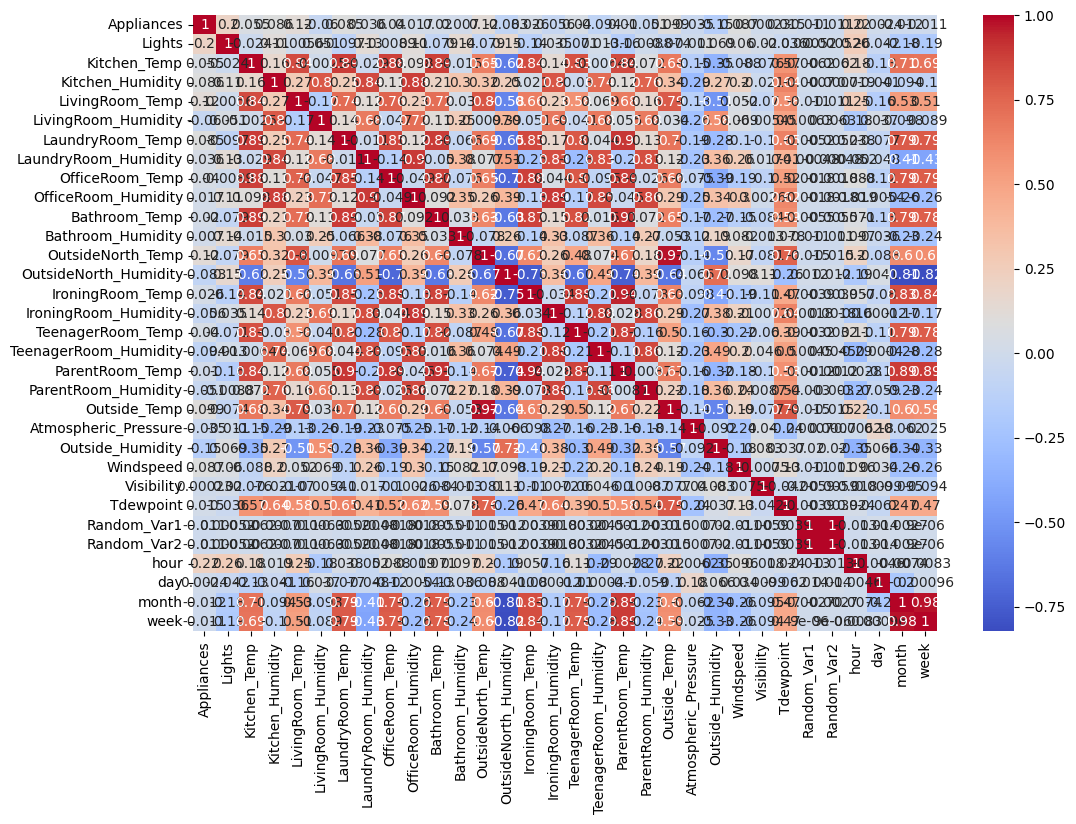

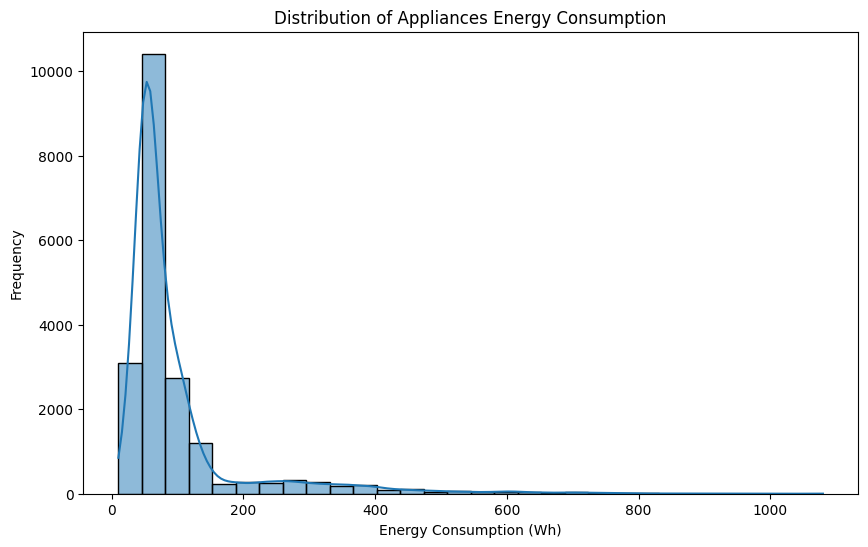

In [6]:
# Correlation matrix to see how features relate to the target variable 'Appliances'
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Distribution of the target variable 'Appliances'
plt.figure(figsize=(10, 6))
sns.histplot(data['Appliances'], kde=True, bins=30)
plt.title('Distribution of Appliances Energy Consumption')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Selecting features and target variable
X = data.drop(columns=['Appliances', 'Lights'])  # Dropping 'lights' as it may not be necessary
y = data['Appliances']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_lr = lr_model.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, R^2: {r2_lr}")


Linear Regression - MAE: 53.400296401366255, RMSE: 92.37550911628023, R^2: 0.14728120247101295


In [10]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test_scaled)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf}, RMSE: {rmse_rf}, R^2: {r2_rf}")


Random Forest - MAE: 29.994552824930327, RMSE: 63.77672350559963, R^2: 0.5935411776632


In [11]:
# Comparing Linear Regression and Random Forest

models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R^2': [r2_lr, r2_rf]
})

print(models)




               Model        MAE       RMSE       R^2
0  Linear Regression  53.400296  92.375509  0.147281
1      Random Forest  29.994553  63.776724  0.593541


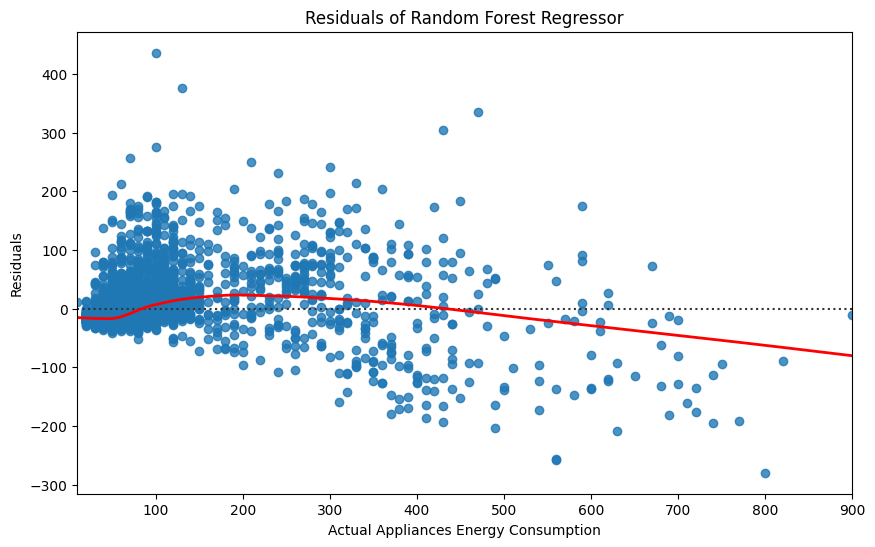

In [12]:
# Residual Plot for Random Forest
plt.figure(figsize=(10, 6))
# Use 'x' and 'y' as named arguments for clarity and compatibility
sns.residplot(x=y_test, y=y_pred_rf, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Residuals of Random Forest Regressor')
plt.xlabel('Actual Appliances Energy Consumption')
plt.ylabel('Residuals')
plt.show()

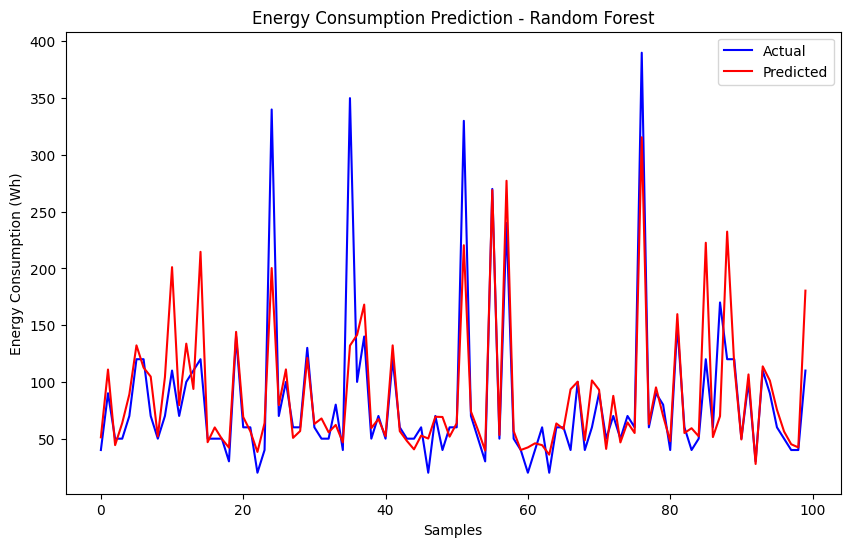

In [13]:
# Visualizing the prediction vs actual for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred_rf[:100], label='Predicted', color='red')
plt.title('Energy Consumption Prediction - Random Forest')
plt.xlabel('Samples')
plt.ylabel('Energy Consumption (Wh)')
plt.legend()
plt.show()
